# Lombard Lending: modeling lending values

Based on Juri (2014), Lending Values and Liquidity Risk

Applied Credit Risk Modeling Seminar FS2021

Hubert Mrugala and Wenqi Li

## Packages, functions and the data

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels
import scipy.stats as st

# Calculate log returns
def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# ---------------------------------

def mean(log_prices):
    return log_prices.mean()

def std(log_prices):
    return log_prices.std()

def annualized_volatility(log_prices):
    return log_prices.std() * np.sqrt(252)

# ---------------------------------

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv

# Estimate gamma by using ADTV
def gamma_est(ADTV,a_hat,b_hat):
    return 10**a_hat*ADTV**b_hat

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta,gamma,x):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv_adj = ( (1-alpha)*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv_adj

def lvx(log_returns,alpha,epsilon,delta,gamma,x_range):
    lvs = []
    for i in range(len(x_range)):
        lv_adj = LV_adj(log_returns,
                        alpha,epsilon,delta,
                        gamma,
                        x_range[i])
        lvs.append(lv_adj)
    return lvs

def LV_series(logs):
    lvs = []
    for i in range(len(logs)):
        lv = LV(logs[:i],alpha,epsilon,delta)
        lvs.append(lv)
    lvs = pd.Series(lvs,index=logs.index).dropna()
    return lvs

# ---------------------------------

def compounded_date(logs,start_date,end_date):
    start_num = (logs == logs[start_date]).argmax()
    end_num = (logs == logs[end_date]).argmax()+1

    comp = []
    for i in range(start_num,end_num):
        ret = logs[start_num:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs[start_num:end_num].index
    return comp

def compounded(logs):
    start = 1
    end = len(logs)

    comp = []
    for i in range(start,end):
        ret = logs[1:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs.index[1:]
    return comp

In [2]:
start_date = '2018-04-03'
end_date = '2021-04-09'

# Load/Create Data
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi_prices.index = pd.to_datetime(smi_prices.index)
smi_logs = log_returns(smi_prices)

smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')[start_date:end_date].interpolate()
smi_vols.index = pd.to_datetime(smi_vols.index)

# ---------------------------------

smi20_prices = pd.read_csv('data/smi_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi20_prices.index = pd.to_datetime(smi20_prices.index)
smi20_logs = log_returns(smi20_prices)

sp500_prices = pd.read_csv('data/sp500_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
sp500_prices.index = pd.to_datetime(sp500_prices.index)
sp500_logs = log_returns(smi_prices)

# ---------------------------------

selected = ['Credit Suisse','Richemont','Swisscom','SGS']

selected_prices = smi_prices[selected]
selected_vols = smi_vols[selected]
selected_logs = smi_logs[selected]

# ---------------------------------

cs_prices = smi_prices['Credit Suisse']
cs_logs = smi_logs['Credit Suisse']

rich_prices = smi_prices['Richemont']
rich_logs = smi_logs['Richemont']

scom_prices = smi_prices['Swisscom']
scom_logs = smi_logs['Swisscom']

sgs_prices = smi_prices['SGS']
sgs_logs = smi_logs['SGS']

## Lending Value Model

In [3]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

In [24]:
# Base LV model for smi20
smi_n = len(smi_logs.columns) # number of assets
smi_names = list(smi_logs.columns) # names of firms

smi_lvs = []
for i in range(smi_n):
    lv = LV(smi_logs.iloc[:,i],alpha,epsilon,delta)
    smi_lvs.append(lv)
smi_lvs = pd.DataFrame(smi_lvs,index=smi_names)
smi_lvs.columns = ['Lending Value']

smi_lvs = pd.concat([smi_lvs.round(4),
                         pd.Series(annualized_volatility(smi_logs),name='Annualized Volatility'),],axis=1)\
                    .sort_values('Lending Value',ascending=False).round(2)
smi_lvs

,Lending Value,Annualized Volatility
Nestle,0.91,0.17
Swisscom,0.90,0.18
Givaudan,0.90,0.20
Novartis,0.89,0.20
Roche,0.89,0.21
SGS,0.89,0.20
Geberit,0.88,0.22
Zurich Insurance Group,0.87,0.25
Partners Group,0.86,0.26
ABB,0.86,0.26


In [26]:
sel_lvs = smi_lvs.loc[selected]
sel_lvs

,Lending Value,Annualized Volatility
Credit Suisse,0.79,0.37
Richemont,0.84,0.30
Swisscom,0.90,0.18
SGS,0.89,0.20


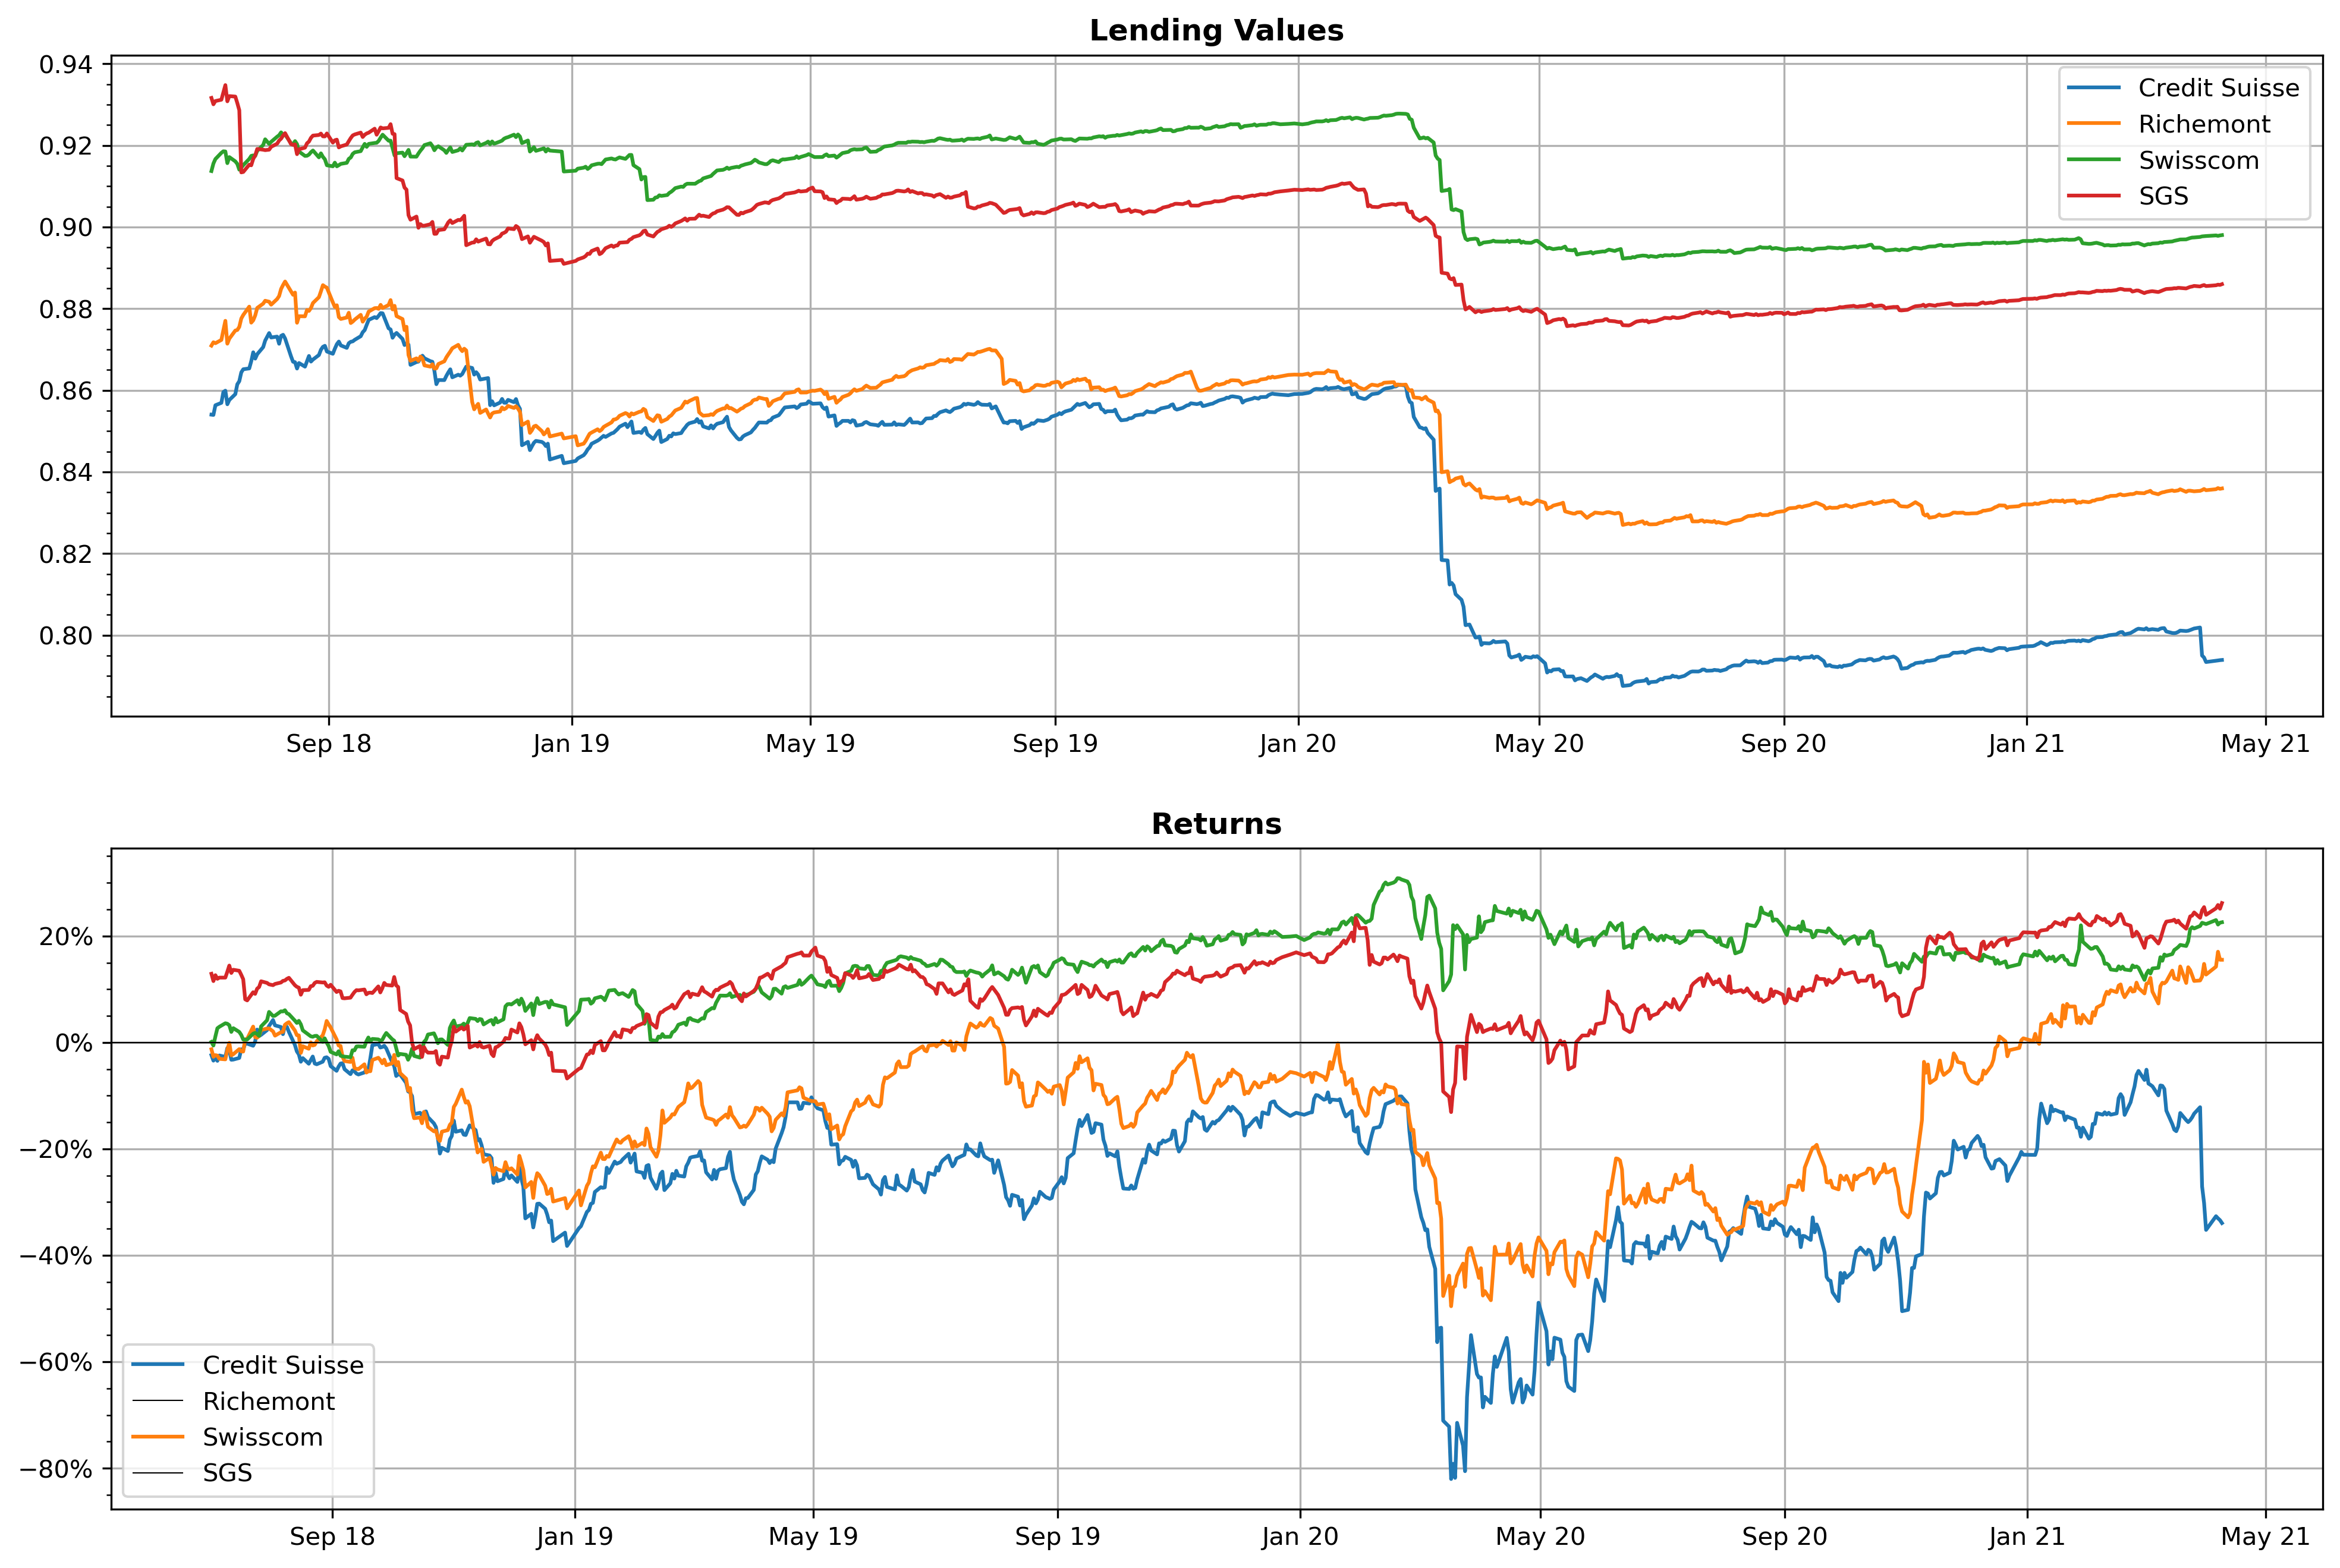

In [27]:
f_lvs, ax = plt.subplots(2,1,figsize=[16,9*1.2],dpi=300)

for i in range(4):
    ax[0].plot(LV_series(selected_logs.iloc[:,i])[60:],lw=1.5)
    ax[0].set_title('Lending Values',fontweight='bold')
for i in range(4):
    ax[1].plot(compounded(selected_logs.iloc[:,i])[60:]*100,lw=1.5)
    ax[1].axhline(0,color='k',lw=0.5)
    ax[1].set_title('Returns',fontweight='bold')
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter())

for i in range(2):
    ax[i].legend(selected)
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax[i].grid()

## Backtesting

In [7]:
st_date = [2019, 4, 23]
td_year = 252 # No of trading days in a year

In [8]:
def contract_sel_plot(contract_starts_date,contract_days):

    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 

    h1_cs = 1-LV(cs_logs[:start_date],alpha,epsilon,delta)
    h1_rich = 1-LV(rich_logs[:start_date],alpha,epsilon,delta)
    h1_scom = 1-LV(scom_logs[:start_date],alpha,epsilon,delta)
    h1_sgs = 1-LV(sgs_logs[:start_date],alpha,epsilon,delta)


    fig, ax = plt.subplots(2,2,
                           figsize=[16,9],dpi=100,
                          constrained_layout=True)

    ax[0,0].plot(compounded_date(cs_logs,start_date,end_date),lw=2)
    ax[0,0].axhline(y=-h1_cs,c='k')
    ax[0,0].set_title(selected[0],fontweight='bold')

    ax[0,1].plot(compounded_date(rich_logs,start_date,end_date),lw=2)
    ax[0,1].axhline(y=-h1_rich,c='k')
    ax[0,1].set_title(selected[1],fontweight='bold')

    ax[1,0].plot(compounded_date(scom_logs,start_date,end_date),lw=2)
    ax[1,0].axhline(y=-h1_scom,c='k')
    ax[1,0].set_title(selected[2],fontweight='bold')

    ax[1,1].plot(compounded_date(sgs_logs,start_date,end_date),lw=2)
    ax[1,1].axhline(y=-h1_sgs,c='k')
    ax[1,1].set_title(selected[3],fontweight='bold')

    for i in range(2):
        for j in range(2):
            ax[i,j].yaxis.set_minor_locator(ticker.AutoMinorLocator())
            ax[i,j].xaxis.set_major_locator(mdates.AutoDateLocator())    
            ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].grid()
    
def margincall(logs,contract_starts_date,contract_days):
    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    haircut = 1-lv
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-haircut)]
    return mcstate

def margincall_days(logs,contract_starts_date,contract_days):
    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    haircut = 1-lv
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-haircut)]
    mcstate_dates = len(mcstate)
    freq = mcstate_dates / len(logs[start_date:end_date])
    return mcstate_dates, freq

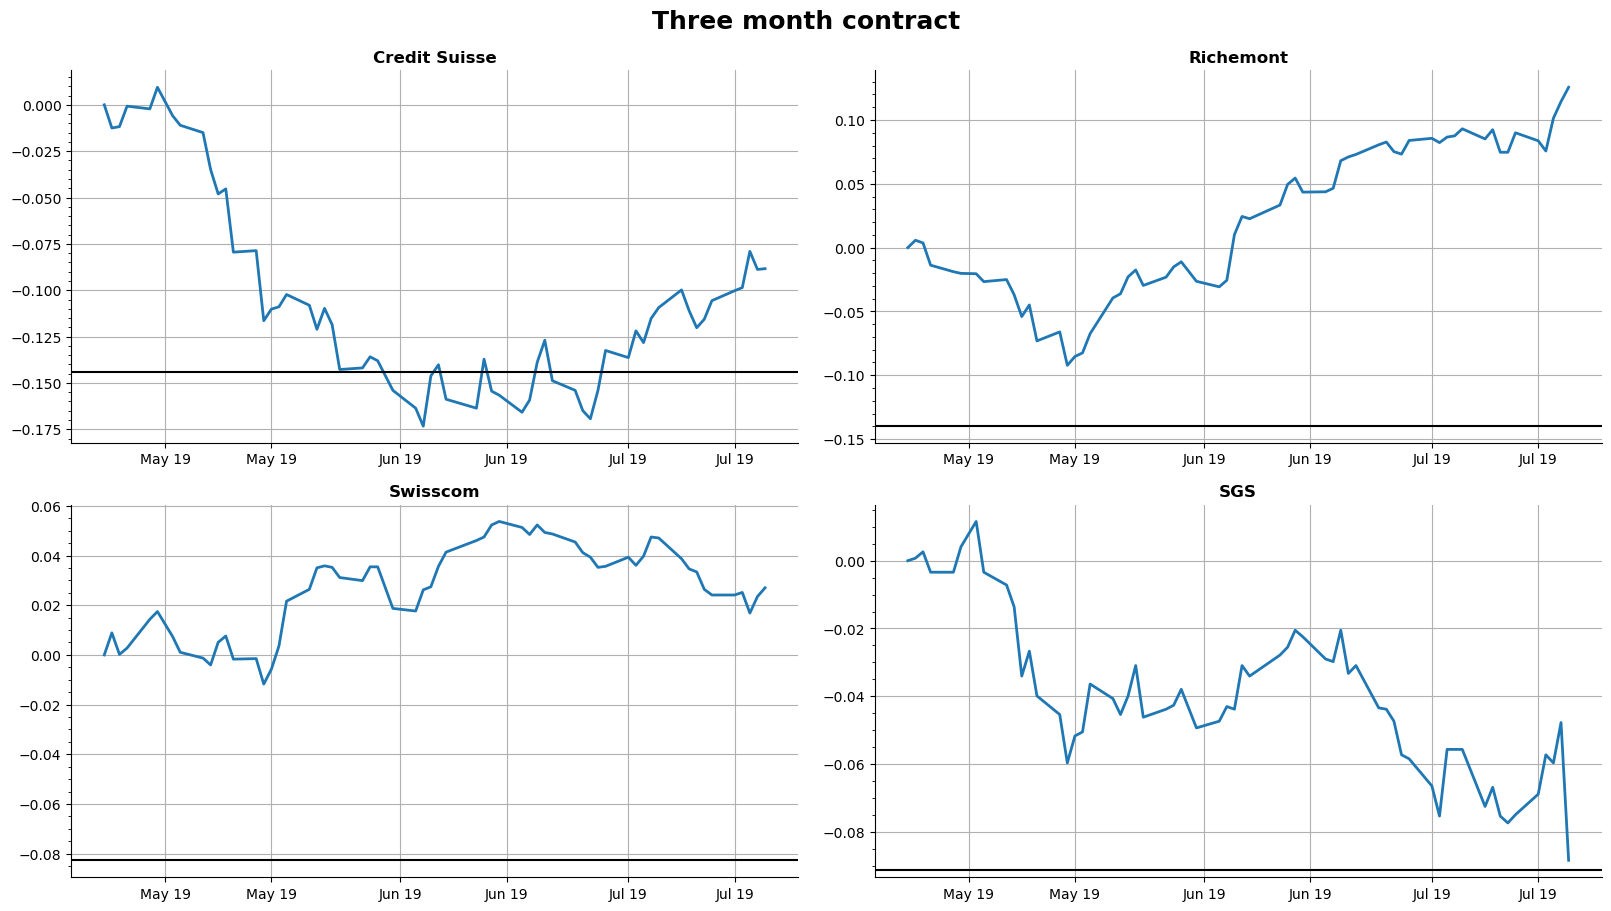

In [29]:
contract_sel_plot(st_date,td_year/4)
_ = plt.suptitle('Three month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/3m_loan.png')

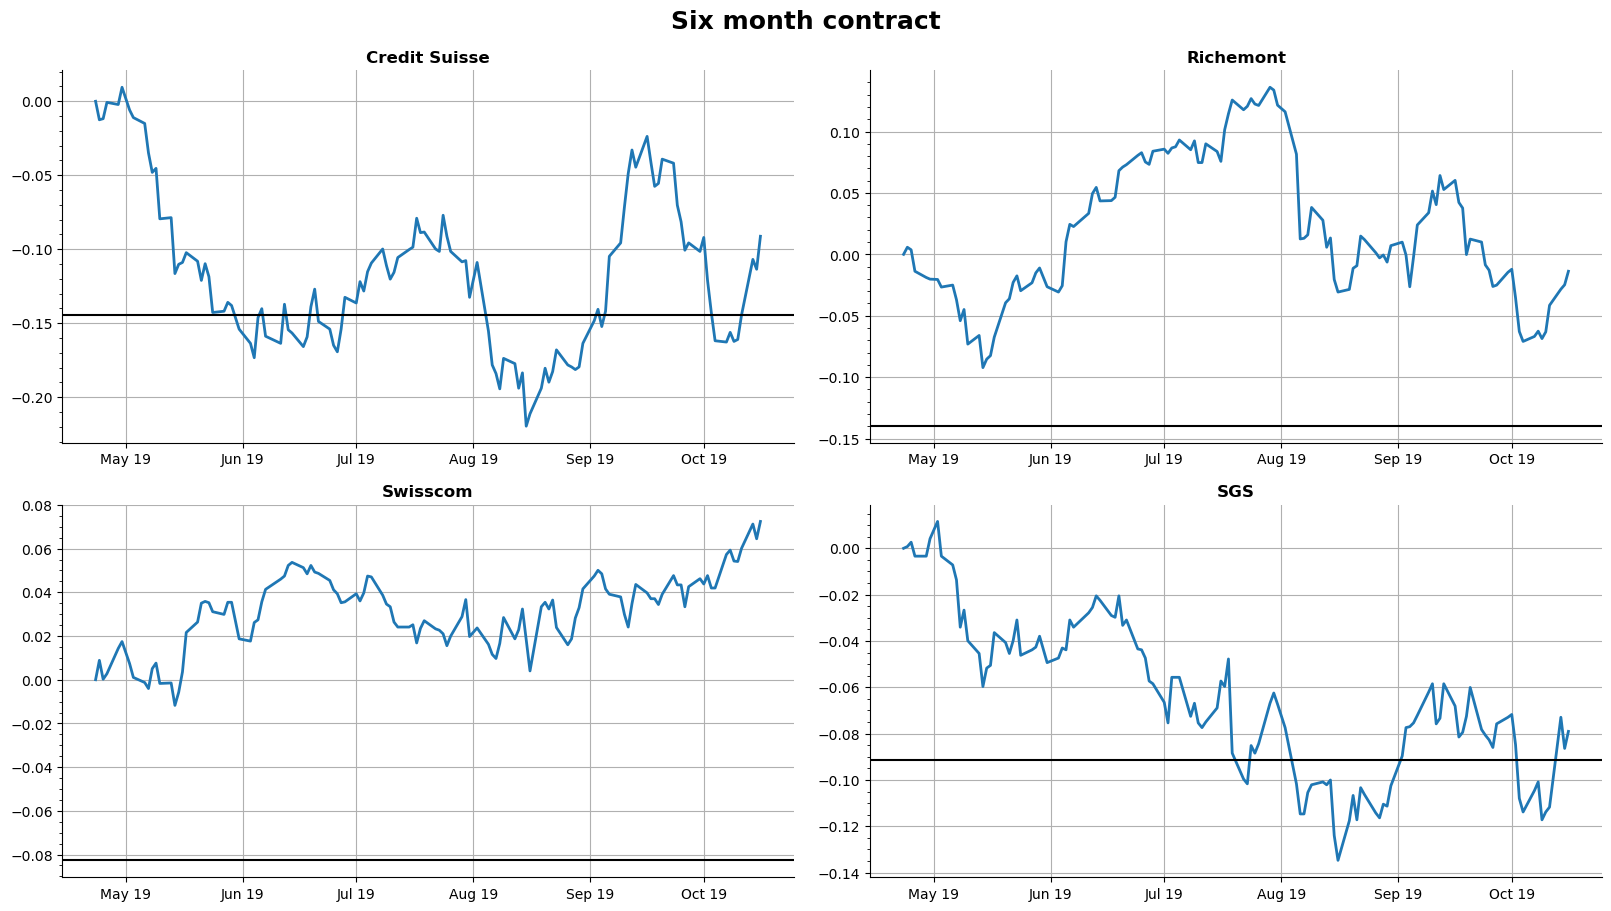

In [32]:
contract_sel_plot(st_date,td_year/2)
_ = plt.suptitle('Six month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/6m_loan.png')

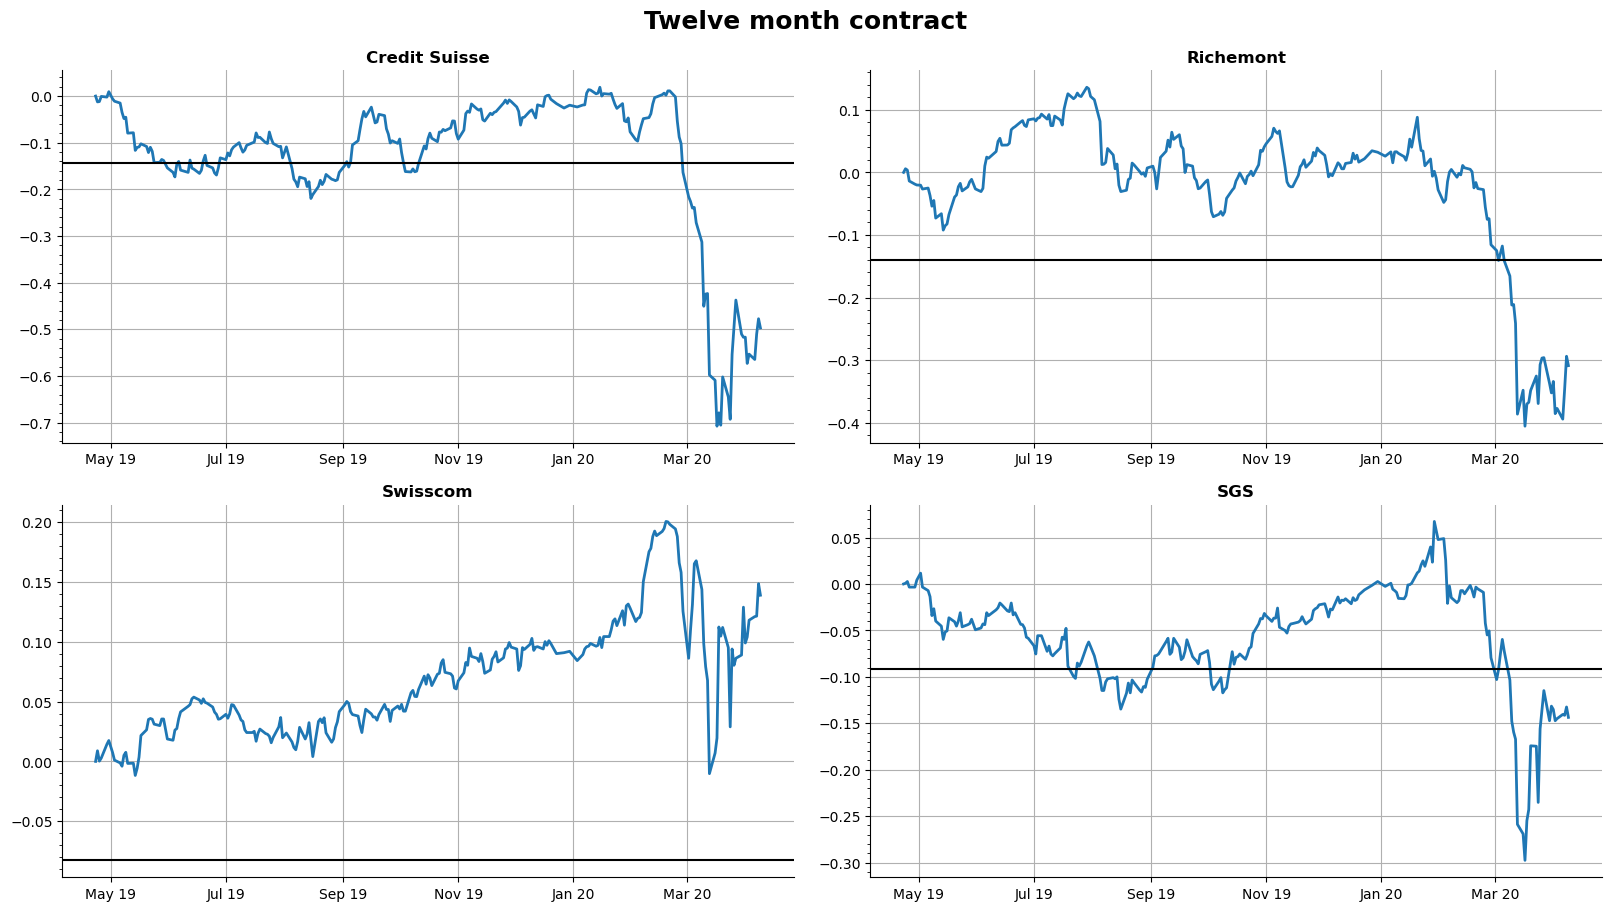

In [33]:
contract_sel_plot(st_date,td_year)
_ = plt.suptitle('Twelve month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/12m_loan.png')

In [12]:
def defaults(logs,contract_starts_date,contract_days):
    mcd = margincall(logs,contract_starts_date,contract_days)
    n = len(mcd)
    
    mcd = mcd.index
    mcd.freq = None

    td = pd.tseries.offsets.BDay(9)
    
    default = []
    for i in range(n):
        cons_bdays = pd.bdate_range(mcd[i],mcd[i]+td)
        cons_bdays.freq = None

        mcd = [i for i in mcd]
        cons_bdays = [i for i in cons_bdays]

        df = pd.DataFrame([mcd,
                           cons_bdays]).T
        df.columns = ['MC','Bdays']
        df = pd.concat([df['MC'].shift(-i),
                        df['Bdays']],
                       axis=1)[:10]
        ver = (df['MC'] == df['Bdays']).all()
        default.append(ver)

    return default

def loan_default(logs,contract_starts_date,contract_days):
    default = defaults(logs,contract_starts_date,contract_days)
    
    if np.array(default).any() == True:
        return 1
    else:
        return 0

def default_date(logs,contract_starts_date,contract_days):
    td = pd.tseries.offsets.BDay(9)
    if loan_default(logs,contract_starts_date,contract_days) == 1:
        d = [int(i) for i in defaults(logs,contract_starts_date,contract_days)]
        mc = [i for i in margincall(logs,contract_starts_date,contract_days).index]
        df = pd.DataFrame([mc,d]).T
        default = df[df[1] == 1].iloc[0,0]
        default_date = default + td
        default_date = default_date.strftime('%d %b %Y')
        return default_date
    else:
        return '-'
    
def default_df(contract_starts_date,contract_days):
    mc = []
    ff = []
    defaul = []
    ddate = []
    for i in range(4):
        mcd = margincall_days(selected_logs.iloc[:,i],
                              contract_starts_date,
                              contract_days)[0]
        mc.append(mcd)
        
        f = margincall_days(selected_logs.iloc[:,i],
                              contract_starts_date,
                              contract_days)[1]
        ff.append(f)

        d = loan_default(selected_logs.iloc[:,i],
                         contract_starts_date,
                         contract_days)
        defaul.append(d)

        dd = default_date(selected_logs.iloc[:,i],
                          contract_starts_date,
                          contract_days)
        ddate.append(dd)
        
    ff = np.array(ff).round(2)
    
    df = pd.DataFrame([mc,ff,defaul,ddate]).T
    df.index = selected
    df.columns = ['# of days in MC state','Frequency','Default','Default Date']
    return df

In [34]:
default_3m = default_df(st_date,td_year/4)
default_3m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,15,0.25,0,-
Richemont,0,0.0,0,-
Swisscom,0,0.0,0,-
SGS,0,0.0,0,-


In [35]:
default_6m = default_df(st_date,td_year/2)
default_6m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,43,0.35,1,16 Aug 2019
Richemont,0,0.0,0,-
Swisscom,0,0.0,0,-
SGS,29,0.24,1,16 Aug 2019


In [36]:
default_12m = default_df(st_date,td_year)
default_12m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,73,0.3,1,16 Aug 2019
Richemont,26,0.11,1,19 Mar 2020
Swisscom,0,0.0,0,-
SGS,55,0.23,1,16 Aug 2019


In [37]:
mc_days = pd.concat([default_df(st_date,td_year/4).iloc[:,0],
                     default_df(st_date,td_year/2).iloc[:,0],
                     default_df(st_date,td_year).iloc[:,0]],axis=1)
mc_days.columns = ['Three month loan','Six month loan','One year loan']
mc_days

,Three month loan,Six month loan,One year loan
Credit Suisse,15,43,73
Richemont,0,0,26
Swisscom,0,0,0
SGS,0,29,55


## Adjusted for Liquidity

In [18]:
a_hat_juri = -1.87096
b_hat_juri = -0.794554

In [19]:
smi_adtv = ADTV(smi_vols)['ADTV - Last month']
smi_adtv.name = 'ADTV'

In [38]:
smi_gamma = []
for i in smi_adtv:
    est_i = gamma_est(i,a_hat_juri,b_hat_juri)
    smi_gamma.append(est_i)
smi_gamma = pd.Series(smi_gamma,index=smi_names,name='Gamma')

smi_liq = pd.concat([smi_adtv.round(0).astype(int),
                     smi_gamma],
                    axis=1).sort_values('ADTV',ascending=False)

sel_liq = smi_liq.loc[selected]
sel_liq

,ADTV,Gamma
Credit Suisse,22595017,1.931434e-08
Richemont,1379817,1.780821e-07
Swisscom,184674,8.802315e-07
SGS,23095,4.591796e-06


In [39]:
smi_adjlvs_x0 = []
smi_adjlvs_xthousand = []
smi_adjlvs_xmil = []
smi_adjlvs_x2adtv = []

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  0)
    smi_adjlvs_x0.append(adjlv)

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xthousand.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_xmil.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  smi_adtv[i]*2)
    smi_adjlvs_x2adtv.append(adjlv)

smi_adjlvs = pd.DataFrame([smi_adjlvs_x0,smi_adjlvs_xthousand,smi_adjlvs_xmil,smi_adjlvs_x2adtv],
                          index=['x = 0','x = 1 000','x =1 000 000','x = ADTV x 2'],
                          columns=smi_names).T.sort_values('x = 0',ascending=False).round(4)*100
smi_adjlvs

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Nestle,90.92,42.04,42.04,42.04
Swisscom,89.80,59.90,59.90,59.90
Givaudan,89.56,68.22,68.22,68.22
Novartis,88.71,40.60,40.60,40.60
Roche,88.65,47.49,47.49,47.49
SGS,88.62,67.85,67.85,67.85
Geberit,88.12,61.55,61.55,61.55
Zurich Insurance Group,86.64,52.12,52.12,52.12
Partners Group,86.48,62.49,62.49,62.49
ABB,85.79,38.74,38.74,38.74


In [40]:
sel_adjlvs =smi_adjlvs.loc[selected]
sel_adjlvs

,x = 0,x = 1 000,x =1 000 000,x = ADTV x 2
Credit Suisse,79.36,28.73,28.73,28.73
Richemont,83.60,46.15,46.15,46.15
Swisscom,89.80,59.90,59.90,59.90
SGS,88.62,67.85,67.85,67.85


In [49]:
x_range = np.arange(0,10**8,10**3)

In [50]:
cs_lvx = lvx(smi_logs.loc[:,'Credit Suisse'],
             alpha,epsilon,delta,
             smi_gamma['Credit Suisse'],
             x_range)
rich_lvx = lvx(smi_logs.loc[:,'Richemont'],
             alpha,epsilon,delta,
             smi_gamma['Richemont'],
             x_range)
scom_lvx = lvx(smi_logs.loc[:,'Swisscom'],
             alpha,epsilon,delta,
             smi_gamma['Swisscom'],
             x_range)
sgs_lvx = lvx(smi_logs.loc[:,'SGS'],
             alpha,epsilon,delta,
             smi_gamma['SGS'],
             x_range)

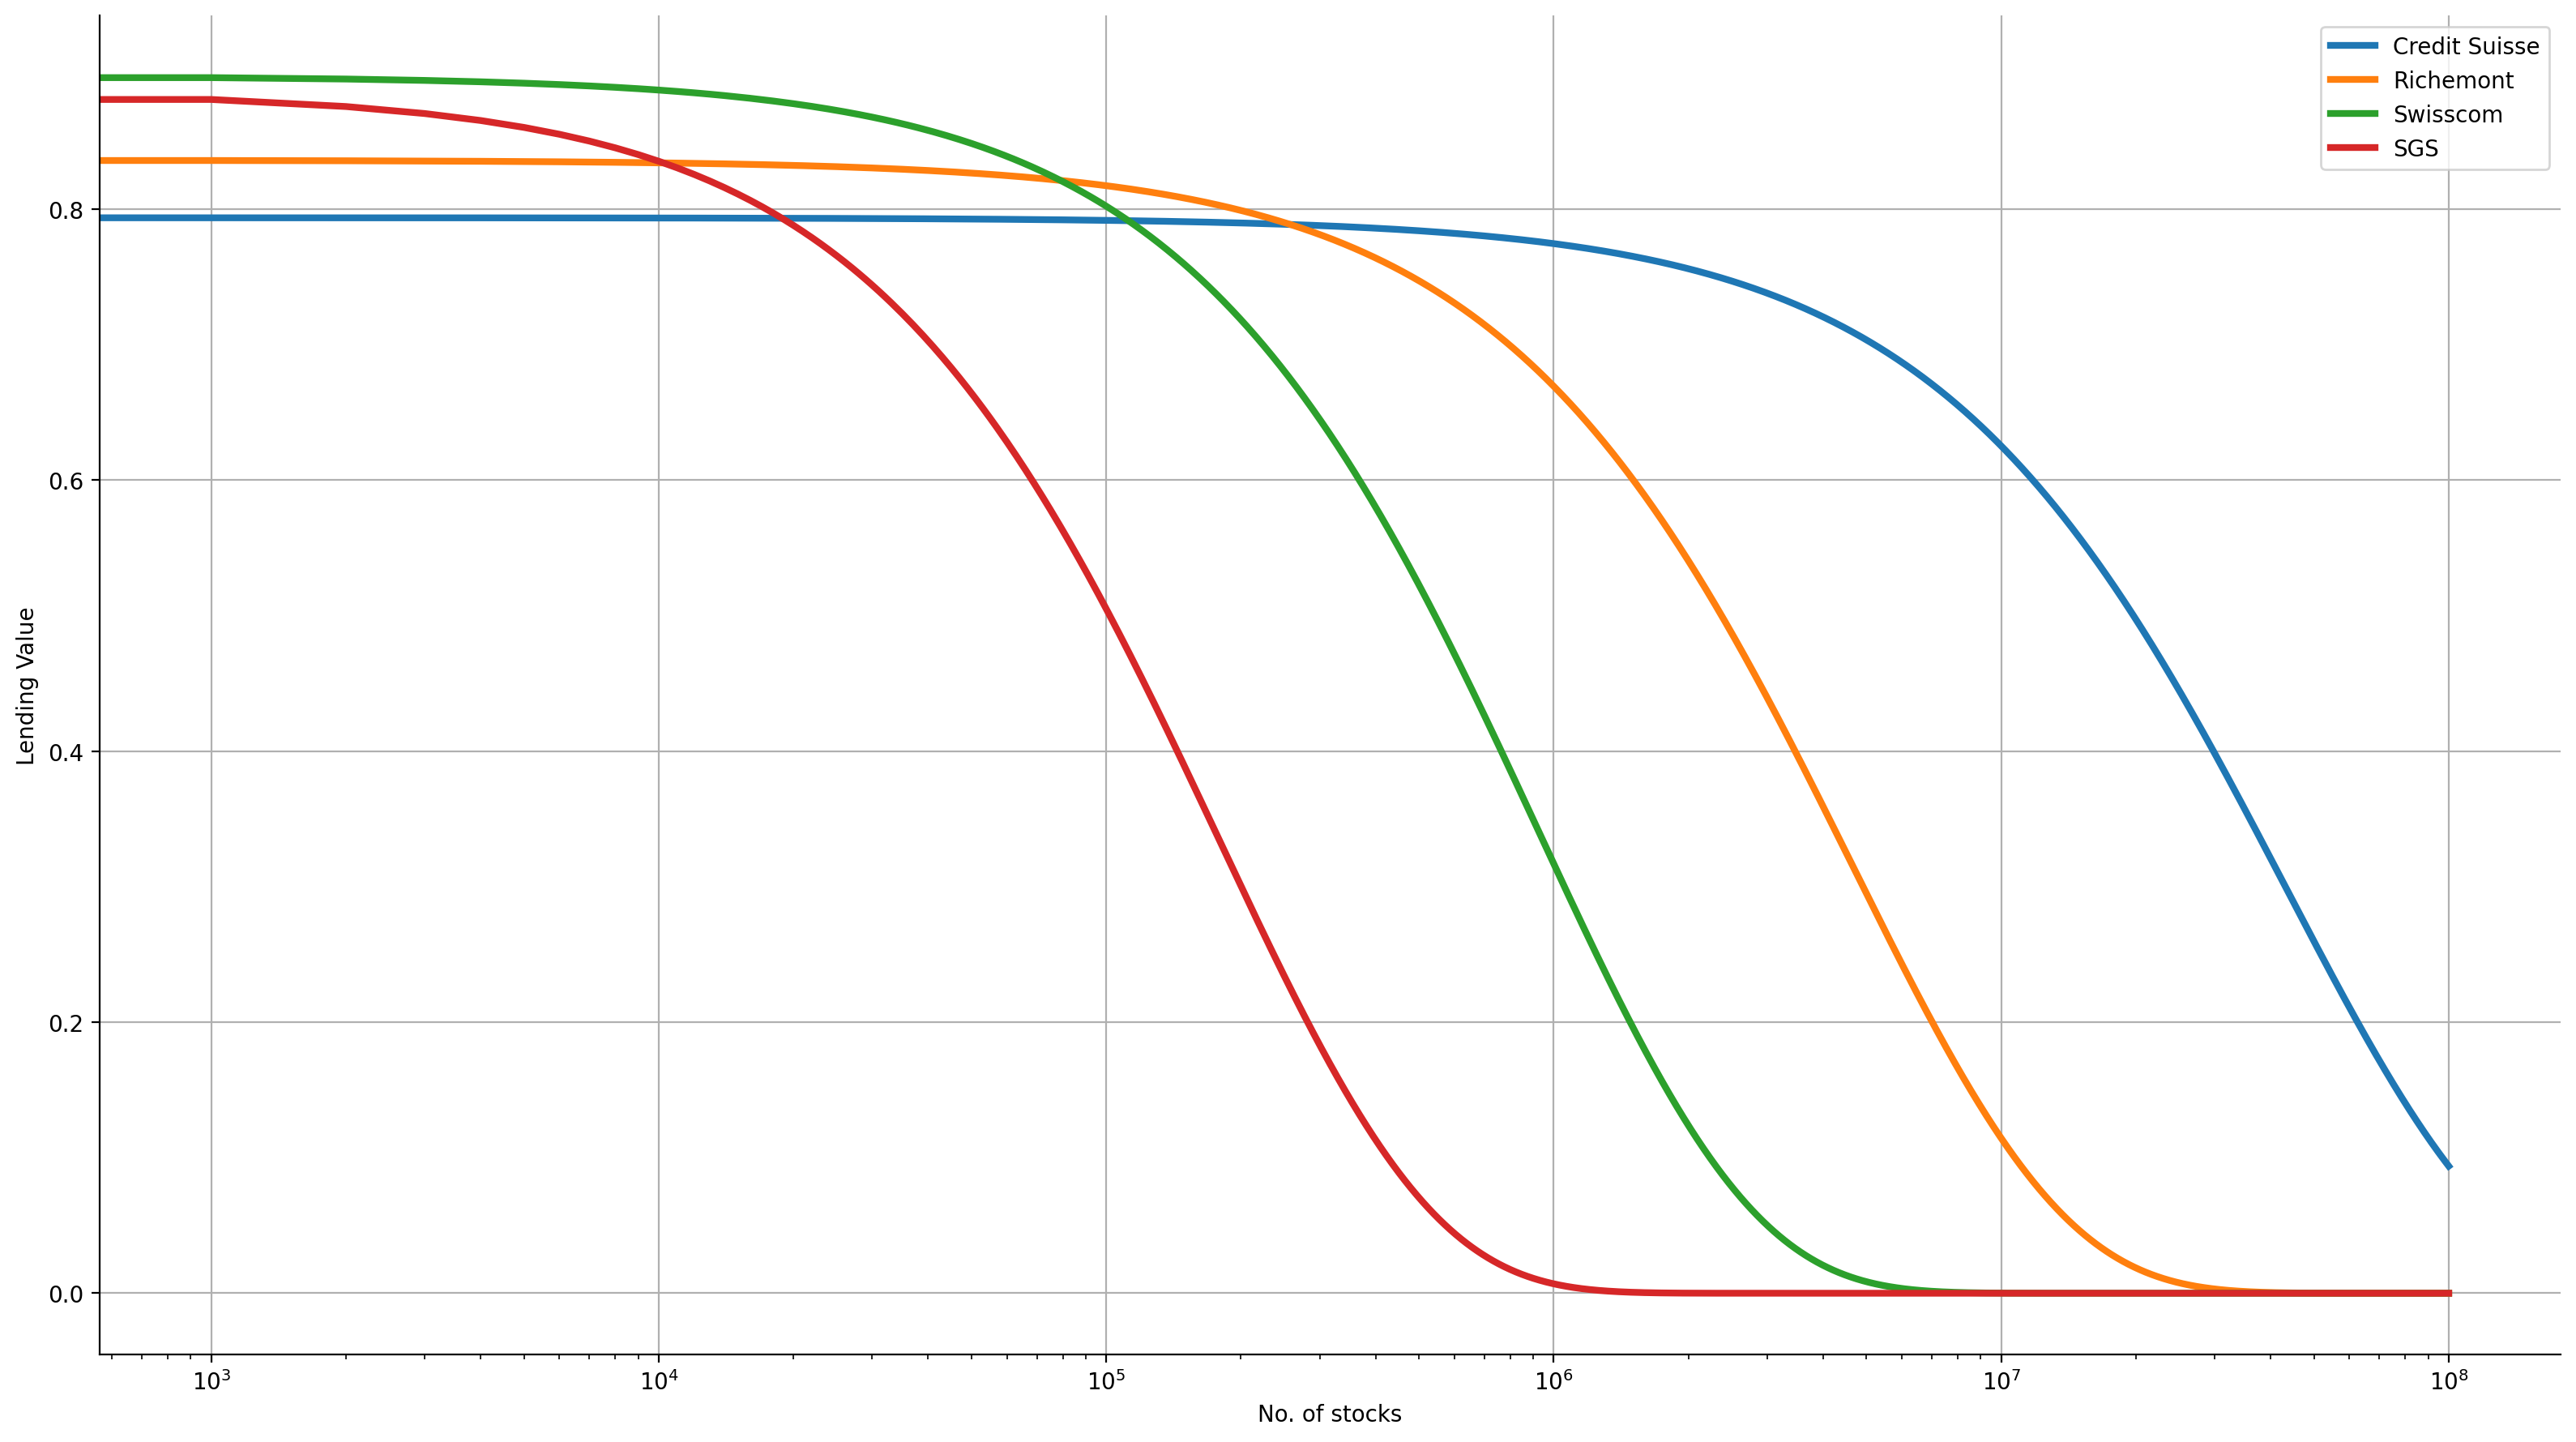

In [52]:
f_lvx ,ax = plt.subplots(1,1,figsize=[16,9],dpi=200)
ax.plot(x_range,cs_lvx,lw=3)
ax.plot(x_range,rich_lvx,lw=3)
ax.plot(x_range,scom_lvx,lw=3)
ax.plot(x_range,sgs_lvx,lw=3)

ax.set_xscale('log')
ax.set_xlabel('No. of stocks')
ax.set_ylabel('Lending Value')
ax.legend(selected)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.grid()
plt.tight_layout()

In [54]:
# Export
smi_lvs.to_latex('output/results/smi_lvs')
sel_lvs.to_latex('output/results/sel_lvs')
mc_days.to_latex('output/results/mc_days')
default_3m.to_latex('output/results/default_3m')
default_6m.to_latex('output/results/default_6m')
default_12m.to_latex('output/results/default_12m')
sel_liq.to_latex('output/results/sel_liq')
smi_adjlvs.to_latex('output/results/smi_adjlvs')
sel_adjlvs.to_latex('output/results/sel_adjlvs')

f_lvs.savefig('output/figures/lvs.png')
f_lvx.savefig('output/figures/lvx.png')